In [3]:
import numpy as np
import torch
import datetime
import os
import base64
import pandas as pd
from collections import Counter
from tqdm import tqdm
import sqlite3
from utils.pipeline import get_files
from utils.data_analysis import get_overlap_undefined,get_direction_info
from utils.types import Direction
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 1000)  # Adjust the number as needed
pd.set_option('display.max_columns', 1000)  # Adjust the number as needed

files = get_files('/home/diego/Documents/yolov7-tracker/runs/detect/2024_04_17_conce_bytetrack')
db = files['db']
FRAME_NUMBER = 15
conn = sqlite3.connect(db)
bbox = pd.read_sql('SELECT * FROM bbox_raw', conn)
bbox['direction'] = bbox.apply(lambda row: ('undefined' if row['img_name'].split('_')[3] == 'None' else  row['img_name'].split('_')[3]) if row['img_name'] is not None else None, axis=1)
bbox['time_sec'] = bbox.apply(lambda row: int(row['frame_number']) // FRAME_NUMBER, axis=1)
bbox['time_video'] = pd.to_datetime(bbox['time_sec'], unit='s').dt.time


In [2]:
get_direction_info(bbox)

{'undefined': 1466, 'out': 590, 'in': 565, 'cross': 64}

In [3]:
overlap_results = get_overlap_undefined(bbox, 0,['undefined'])
overlap_results.to_csv('overlap_results_undefined_2.csv', index=False)

overlap_results = get_overlap_undefined(bbox, 0,[Direction.In.value, Direction.Out.value])
overlap_results.to_csv('overlap_results_in_out_2.csv', index=False)

In [ ]:
overlap_results['overlap_type'].value_counts()

In [ ]:
analysis.to_csv('analysis.csv', index=False)

In [ ]:
intervals = group_by_interval(filtered_df)
total = count_ids_in_intervals(intervals)
#print(total)

with open('intervals.json', 'w') as f:
	f.write(str(intervals))
 
with open('total.json', 'w') as f:
	f.write(str(total))

In [ ]:
intervals[35750]

In [ ]:
filtered_df.to_csv('bbox_2.csv', index=False)

In [79]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress


def create_plot(df, primary_id,unique_ids, intersecting_id_colors=['green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown']):
    slopes = {}
    for unique_id in unique_ids:
        id_data = df[df['id'] == unique_id]
        slope, intercept, r_value, p_value, std_err = linregress(id_data['frame_number'], id_data['distance_to_center'])
        slopes[unique_id] = slope
        
    reference_slope = slopes[primary_id]  # You need to define this
    normalized_slopes = {unique_id: slope / reference_slope for unique_id, slope in slopes.items()}
    
    
    
    scaled_slopes = {}
    for unique_id in unique_ids:
        id_data = df[df['id'] == unique_id]
        min_y = id_data['distance_to_center'].min()
        max_y = id_data['distance_to_center'].max()
        scaled_slopes[unique_id] = (slopes[unique_id] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    
    standardized_slopes = {}
    for unique_id in unique_ids:
        id_data = df[df['id'] == unique_id]
        mean_y = id_data['distance_to_center'].mean()
        std_y = id_data['distance_to_center'].std()
        standardized_slopes[unique_id] = (slopes[unique_id] - mean_y) / std_y if std_y != 0 else 0

    
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size as needed

    # Filter the dataframe for the primary ID and sort it
    df_primary_id = df[df['id'] == primary_id].sort_values(by='frame_number')

    # Scatter plot for the primary ID with different colors for positive and negative distances
    positive_distance = df_primary_id['distance_to_center'] > 0
    ax.scatter(df_primary_id[positive_distance]['frame_number'], df_primary_id[positive_distance]['distance_to_center'],
               c='blue', s=10, alpha=0.6, label=f'ID {primary_id} In')
    ax.scatter(df_primary_id[~positive_distance]['frame_number'], df_primary_id[~positive_distance]['distance_to_center'],
               c='red', s=10, alpha=0.6, label=f'ID {primary_id} Out')

    # Calculate the time frame start and end
    timeframe_start = df['frame_number'].min()
    timeframe_end = df['frame_number'].max()

    # Identify other intersecting IDs within this timeframe
    intersecting_ids = df[(df['frame_number'] >= timeframe_start) & 
                          (df['frame_number'] <= timeframe_end) & 
                          (df['id'] != primary_id)]['id'].unique()

    # Plot data for each intersecting ID within the timeframe
    for idx, other_id in enumerate(intersecting_ids):
        df_other_id = df[(df['id'] == other_id) & 
                         (df['frame_number'] >= timeframe_start) & 
                         (df['frame_number'] <= timeframe_end)]
        color = intersecting_id_colors[idx % len(intersecting_id_colors)]
        ax.scatter(df_other_id['frame_number'], df_other_id['distance_to_center'], 
                   c=color, s=20, edgecolor='k', label=f'ID {other_id}')
    
    # Plot formatting
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlim(timeframe_start - 10, timeframe_end + 10)  # A little space around the edges
    ax.set_ylim(df['distance_to_center'].min() - 10, df['distance_to_center'].max() + 10)

    # Construct the title to include the ID and its timeframe
    duration = timeframe_end - timeframe_start
    title_text = f'ID {primary_id}: #{duration} '
    ax.set_title(title_text, color='red')

    ax.set_xlabel('Frame Number')
    ax.set_ylabel('Distance to Center')
    ax.legend(loc='upper left', fontsize='small')
    slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in slopes.items()])
    fig.text(0.5, 0.01, f"{slopes_text} = slopes", ha='center', va='center', fontsize=10, color='green', style='italic')  # Adjust the position and style as needed
    
    normalized_slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in normalized_slopes.items()])
    fig.text(0.5, -0.02, f"{normalized_slopes_text} = normalized", ha='center', va='center', fontsize=10, color='blue', style='italic')  # Adjust the position and style as needed
    
    scaled_slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in scaled_slopes.items()])
    fig.text(0.5, -0.05, f"{scaled_slopes_text} = scaled", ha='center', va='center', fontsize=10, color='blue', style='italic')  # Adjust the position and style as needed
    
    standardized_slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in standardized_slopes.items()])
    fig.text(0.5, -0.08, f"{standardized_slopes_text} = standardized", ha='center', va='center', fontsize=10, color='blue', style='italic')  # Adjust the position and style as needed
    
    
    
    
    plt.tight_layout()
    plt.show()

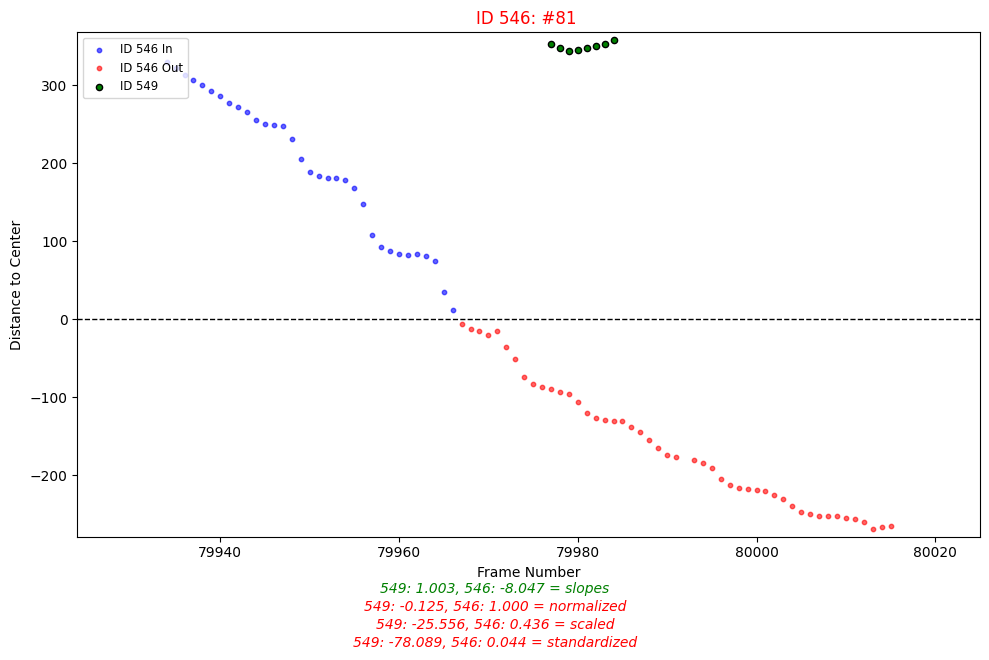

In [80]:
primary_id = 546
query = 'SELECT * FROM overlap_results'
overlap_results = pd.read_sql(query, conn)

overlap_results_only_id = overlap_results[overlap_results['id'] == primary_id]
ids_overlap = list(overlap_results_only_id['id_overlap'])
ids_overlap.append(primary_id)  # Append the integer version of id

query = 'SELECT id, distance_to_center, frame_number FROM bbox_raw WHERE id IN ({})'.format(', '.join(['?']*len(ids_overlap)))
bbox2 = pd.read_sql(query, conn, params=ids_overlap)


plot_path = create_plot(bbox2,primary_id, ids_overlap)

In [25]:
bbox2

,id,distance_to_center,frame_number
0,549,352.33,79977
1,549,347.24,79978
2,549,344.48,79979
3,549,345.50,79980
4,549,347.41,79981
5,549,349.81,79982
6,549,352.68,79983
7,549,357.92,79984
8,546,329.72,79934
9,546,322.28,79935


In [11]:
ids_overlap

[3143, 3145, 3148, 3149, 3154, <function id(obj, /)>]